In [3]:
# Import necessary packages
import torch
import torch.nn as nn
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [4]:
# Load the CSV data
csv_path = os.path.join(os.getcwd(), "NFLX.csv")  # Assuming the CSV file is in the same directory as the script
data = pd.read_csv(csv_path)
target_column = "Close"  # Assuming "Close" is the target column
target = data[target_column].values.reshape(-1, 1)

In [5]:
# Normalize the target values
scaler = MinMaxScaler(feature_range=(-1, 1))
target_normalized = scaler.fit_transform(target)

In [6]:
# Prepare input sequences and target values
sequence_length = 10  # Adjust as needed
data_sequences = []
target_sequences = []

In [8]:
import numpy as np

In [11]:
import torch
import numpy as np

# Assuming you have initialized data_sequences and target_sequences as empty tensors before the loop
data_sequences = torch.tensor([], dtype=torch.float32)
target_sequences = torch.tensor([], dtype=torch.float32)

# Loop to create sequences
for i in range(len(target_normalized) - sequence_length):
    data_seq = torch.tensor(target_normalized[i:i+sequence_length], dtype=torch.float32)
    target_seq = torch.tensor(target_normalized[i+sequence_length:i+sequence_length+1], dtype=torch.float32)

    # Concatenate tensors along the 0th dimension
    data_sequences = torch.cat((data_sequences, data_seq.unsqueeze(0)), dim=0)
    target_sequences = torch.cat((target_sequences, target_seq.unsqueeze(0)), dim=0)

# Convert to NumPy arrays if needed
data_sequences_np = data_sequences.numpy()
target_sequences_np = target_sequences.numpy()


In [17]:
# Split the data into training and testing sets
train_data, test_data = torch.utils.data.random_split(data_sequences, [train_size, test_size])
train_target, test_target = torch.utils.data.random_split(target_sequences, [train_size, test_size])

# Convert to tensors
train_data = torch.stack([item[0] for item in train_data])
test_data = torch.stack([item[0] for item in test_data])

# No need to index into items for train_target and test_target
train_target = torch.stack([item for item in train_target])
test_target = torch.stack([item for item in test_target])

# Create DataLoader
batch_size = 64
train_dataloader = DataLoader(TensorDataset(train_data, train_target), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_data, test_target), batch_size=batch_size, shuffle=False)

In [18]:
# Define the LSTM model
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

In [20]:
# Initialize the model, loss function, and optimizer
model = SimpleLSTMModel(input_size=1, hidden_size=32, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for input_seq, target_seq in train_dataloader:
        optimizer.zero_grad()
        output_seq = model(input_seq.unsqueeze(-1))
        loss = criterion(output_seq, target_seq)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.21278461813926697
Epoch 10, Loss: 0.13158656656742096
Epoch 20, Loss: 0.2126239687204361
Epoch 30, Loss: 0.2558363378047943
Epoch 40, Loss: 0.18176640570163727
Epoch 50, Loss: 0.17048189043998718
Epoch 60, Loss: 0.2693490982055664
Epoch 70, Loss: 0.15821513533592224
Epoch 80, Loss: 0.18939854204654694
Epoch 90, Loss: 0.17453421652317047


In [23]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for input_seq, target_seq in test_dataloader:
        output_seq = model(input_seq.unsqueeze(-1))
        predictions.extend(output_seq.cpu().numpy())
        targets.extend(target_seq.cpu().numpy())


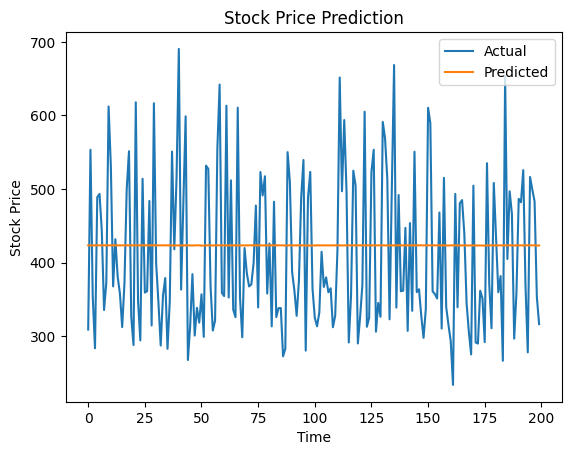

In [26]:
# Convert predictions and targets to NumPy arrays
predictions = np.array(predictions)
targets = np.array(targets)

# Inverse transform the predictions and targets
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
targets = scaler.inverse_transform(targets.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.plot(targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.show()

In [27]:

model_path = 'simple_lstm_model.pth' 
torch.save(model.state_dict(), model_path)

In [29]:
# Load the model
loaded_model = SimpleLSTMModel(input_size=1, hidden_size=32, output_size=1)
loaded_model.load_state_dict(torch.load('simple_lstm_model.pth'))
loaded_model.eval()


SimpleLSTMModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)